In [101]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import torch


In [102]:
# Read the Excel file, treating '--' as missing values
data = pd.read_excel('AD2.xlsx', na_values='--')

In [115]:
selected_rows = [idx for idx in range(len(data)) if idx in range(442, 889) or idx in range(1,441) or idx in range(1336,1651)]

# 提取特徵和目標
X = data.iloc[selected_rows, 14:]  # Starting from the 6th column as feature variables
y = data.iloc[selected_rows]['Group']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Fill missing values with the mean
X = imputer.fit_transform(X)

In [116]:
# Split the dataset into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [117]:
# Define base classifiers
svm_classifier = svm.SVC(C=10, gamma='scale', kernel='poly')
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
lr_classifier = LogisticRegression(max_iter=10000)
knn_classifier = KNeighborsClassifier(n_neighbors=10)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)  
dt_classifier = DecisionTreeClassifier(random_state=42)  

In [118]:
# Create a list of base classifiers for stacking
base_classifiers = [
    ('svm', svm_classifier),
    ('rf', rf_classifier),
    ('lr', lr_classifier),
    ('knn', knn_classifier),
    ('gb', gb_classifier),  
    ('dt', dt_classifier)  
]

# Create the stacking ensemble
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=lr_classifier)

stacking_classifier.fit(X_train_scaled, y_train)


StackingClassifier(estimators=[('svm', SVC(C=10, kernel='poly')),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('lr', LogisticRegression(max_iter=10000)),
                               ('knn', KNeighborsClassifier(n_neighbors=10)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=10000))

Accuracy: 67.78
F1 Score: 67.66
Precision Score: 67.70
Recall Score: 67.78


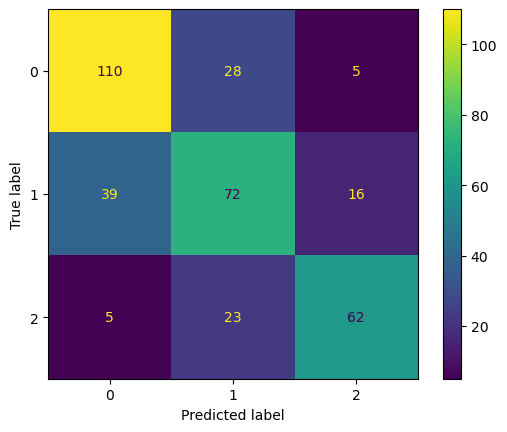

In [119]:
# Use the stacking classifier for predictions
y_pred = stacking_classifier.predict(X_test_scaled)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=stacking_classifier.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=stacking_classifier.classes_)
cm_display.plot()

# Calculate accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy:', "%.2f" % (accuracy * 100))
print('F1 Score:', "%.2f" % (f1 * 100))
print('Precision Score:', "%.2f" % (precision * 100))
print('Recall Score:', "%.2f" % (recall * 100))


In [109]:
# Error rate calculation (similar to your initial code)
error_rate = []


for i in range(1, 10):
    model_new = StackingClassifier(estimators=base_classifiers, final_estimator=lr_classifier)
    model_new.fit(X_train, y_train)
    pred_i = model_new.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# Plot the error rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), error_rate, color='blue', marker='o', markerfacecolor='red')
plt.title('Error Rate vs. stacking')
plt.xlabel('stacking')
plt.ylabel('Error Rate')
plt.show()

KeyboardInterrupt: 